In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
from scipy.stats import norm, pearsonr, spearmanr
import scipy.stats as stats
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

sns.set_context("paper")
simHei = FontProperties(fname=r'/usr/share/fonts/Chinses/simhei.ttf', size=10) 

In [2]:
FDR_THRESHOLD = 0.05 #ASV差异FDR阈值
RANDOM_SEED = 0 #模型随机种子

# Load dataset

In [3]:
asv_data = pd.read_csv('../data/Preprocess/rawdata_16S_abundance.tsv', index_col=0, sep='\t')
taxa_data = pd.read_csv('../data/Preprocess/rawdata_16S_taxa.tsv', index_col=0, sep='\t')

# 1. Difference analysis

In [16]:
from scipy.stats import fisher_exact, ranksums
import statsmodels.stats.multitest as multi
statistic_asv = []
for asv in asv_data.index:
    row = []
    normal_abun = asv_data.loc[asv, [i for i in asv_data.columns if i[0]=='N']]
    pp_abun = asv_data.loc[asv, [i for i in asv_data.columns if i[0]=='P']]
    row.extend([taxa_data.loc[asv, 'Kingdom'], taxa_data.loc[asv, 'Phylum'], taxa_data.loc[asv, 'Class'], 
                taxa_data.loc[asv, 'Order'], taxa_data.loc[asv, 'Family'], taxa_data.loc[asv, 'Genus']])
    row.extend([taxa_data.loc[asv, 'Name'], normal_abun.mean(), pp_abun.mean()])
    ### Normal vs F_PP
    f, p_value = ranksums(pp_abun, normal_abun)
    FC = pp_abun.mean()/normal_abun.mean()
    row.extend([FC, p_value])
    statistic_asv.append(row)
statistic_asv = pd.DataFrame(statistic_asv, index = asv_data.index, 
                             columns = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 
                                        'Name','Normal_mean', 'PP_mean', 'FC','p_value'])
statistic_asv['FDR'] = multi.multipletests(statistic_asv['p_value'], method = 'fdr_bh')[1]

In [17]:
statistic_asv.to_csv('result/2.Microbiome_differential_asv.csv')

# 2. Differential ASVs

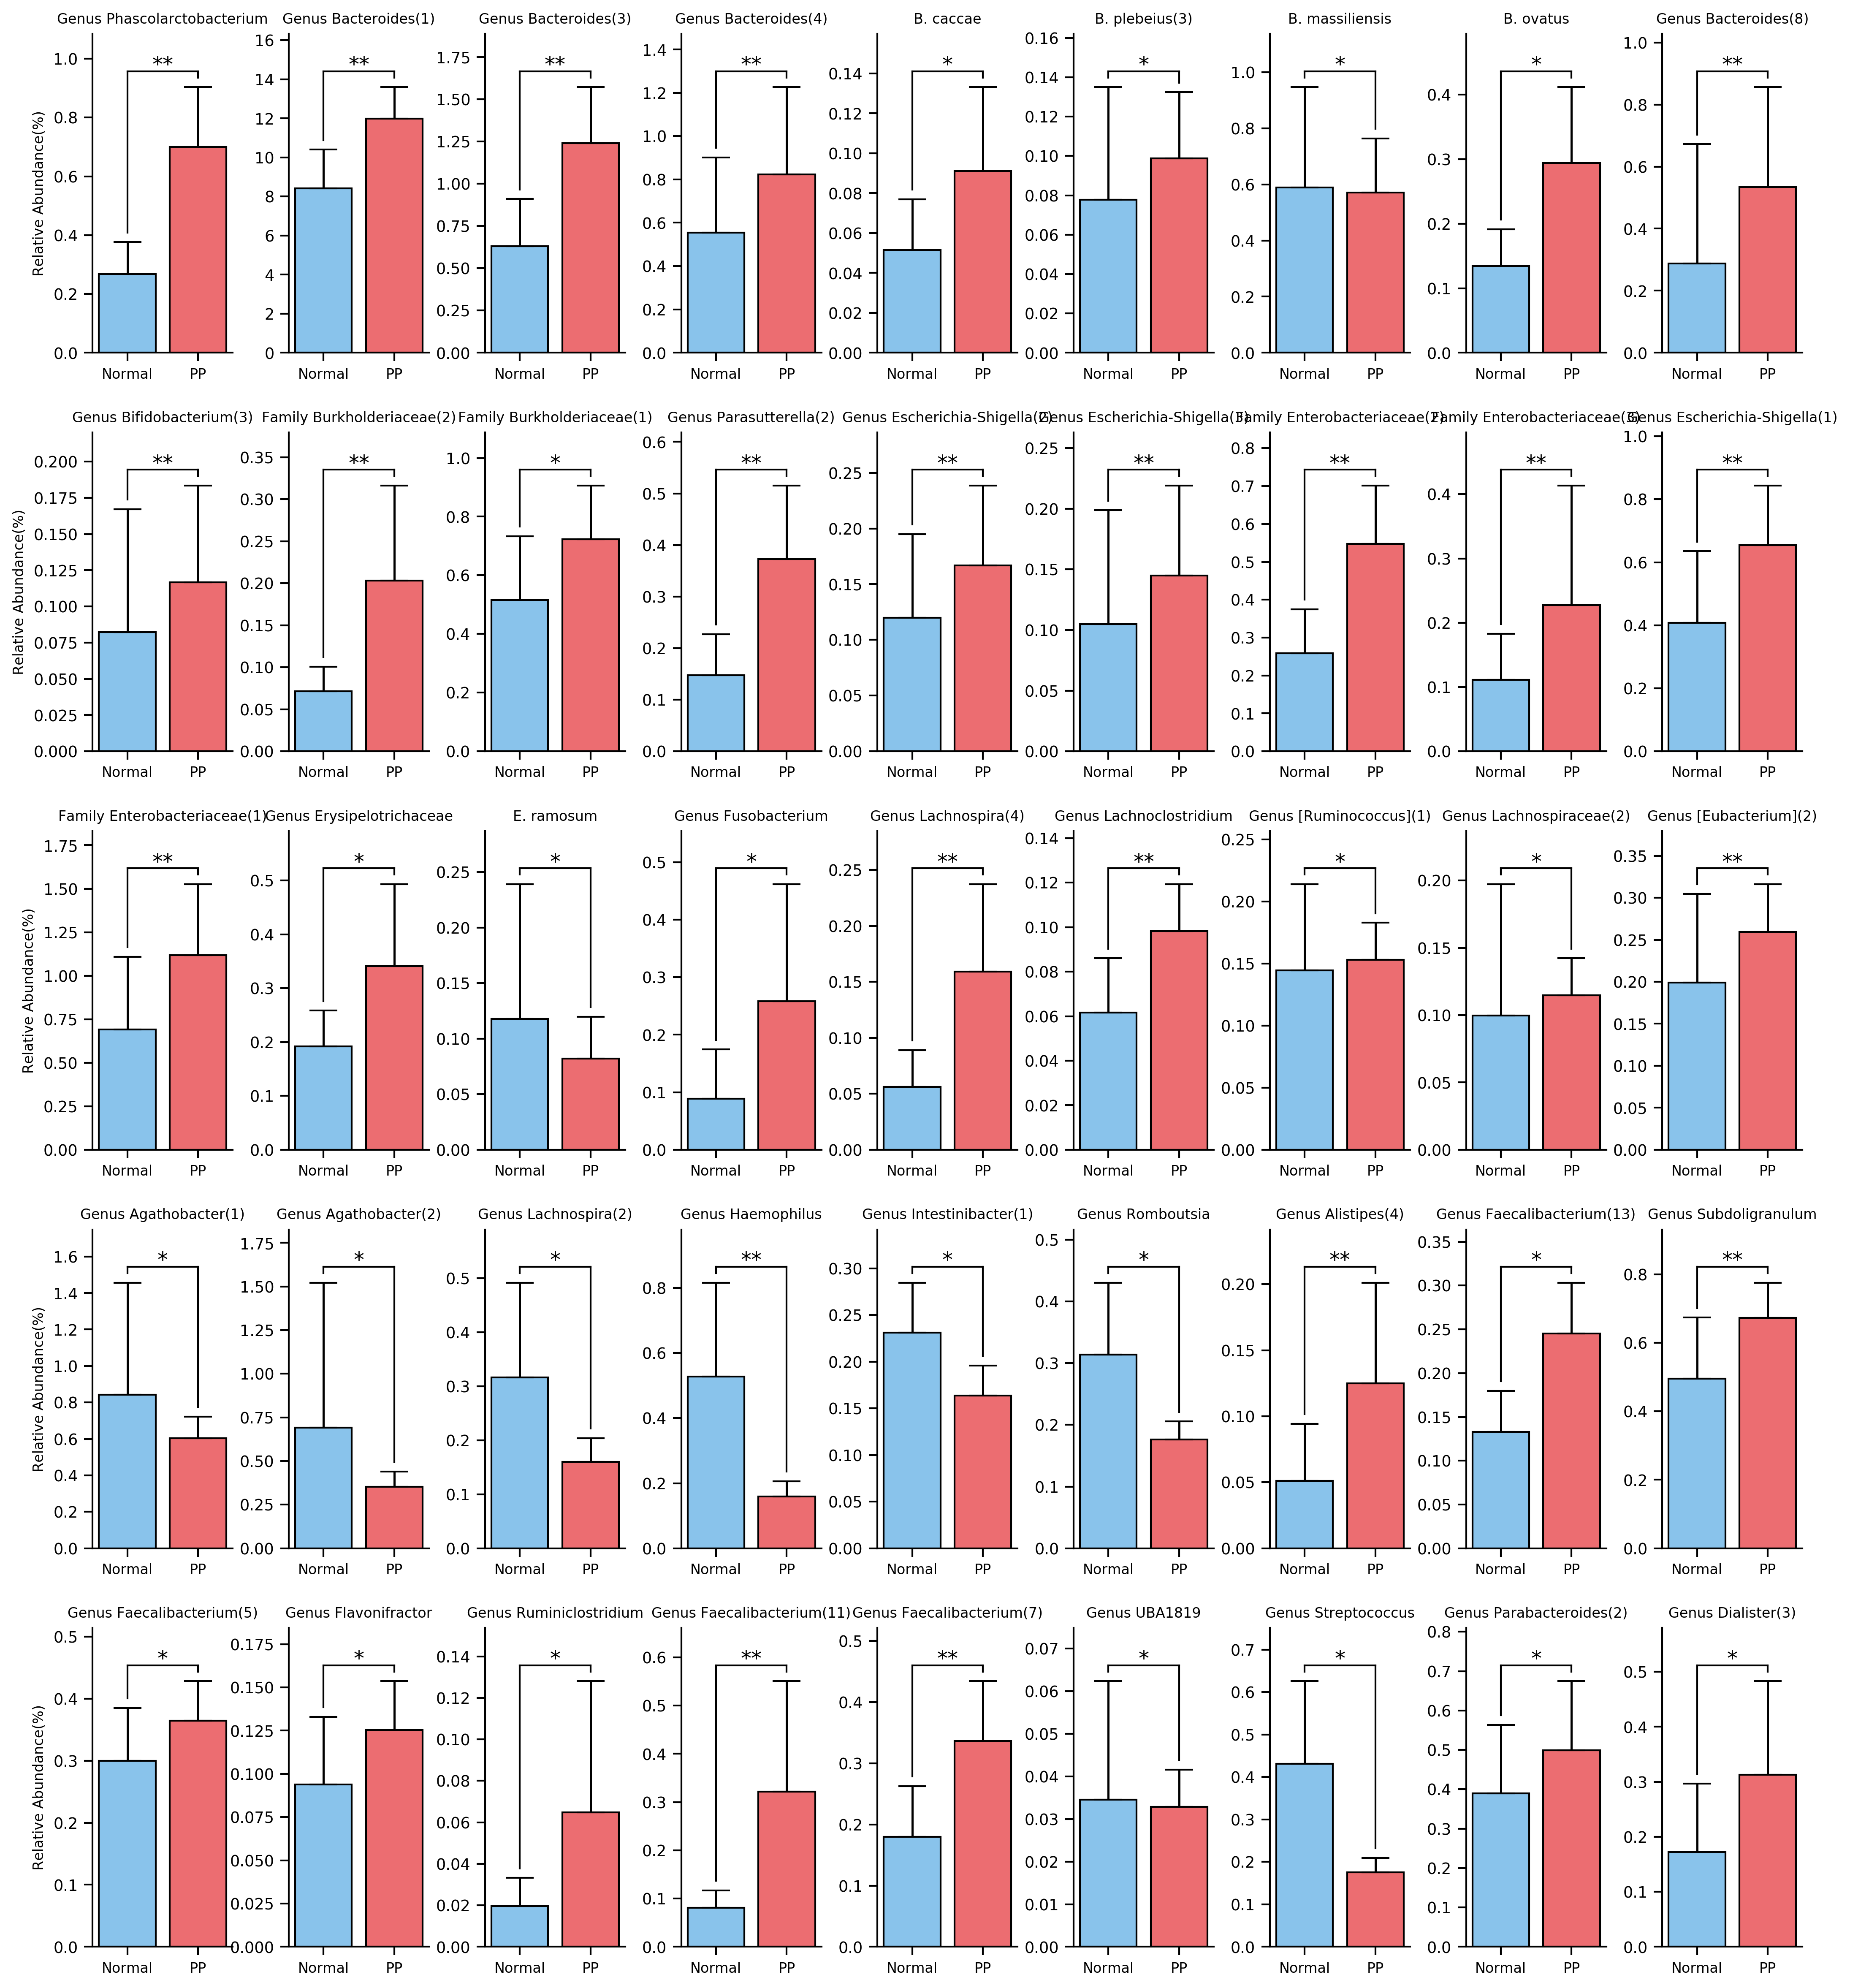

In [146]:
Diff_asv = statistic_asv.loc[statistic_asv['FDR']<=FDR_THRESHOLD, :]
Diff_asv = Diff_asv.sort_values(['Family'])
temp = asv_data.loc[:, :].T.loc[:, Diff_asv.index]
Normal_sample = [i for i in temp.index if 'N' in i]
PP_sample = [i for i in temp.index if 'PP' in i]

_ = plt.figure(figsize=(15, 20), dpi=300)
gs = gridspec.GridSpec(5, 9)
gs.update(left=0.05, right=0.95, wspace=0.4, hspace=0.25)
colors = ['#89c3eb', '#ec6d71']
index = 0
for row in range(5):
    for col in range(9):
        taxon = Diff_asv.index[index]
        name = Diff_asv.loc[taxon, 'Name']
        ax = plt.subplot(gs[row, col])
        means = [temp.loc[Normal_sample, taxon].mean(), temp.loc[PP_sample, taxon].mean()]
        stds = [temp.loc[Normal_sample, taxon].std(), temp.loc[PP_sample, taxon].std()]
        counts = [len(temp.loc[Normal_sample, taxon]), len(temp.loc[PP_sample, taxon])]
        ci95 = 1.96 * np.array(stds) / np.sqrt(np.array(counts)) #95置信区间
        p = ax.bar(x=[0, 0.5], height=means, yerr=[[0, 0], ci95], width=0.4, align='center', color=colors, edgecolor='black', linewidth=1, ecolor='black', capsize=8)
        ### 绘制显著性
        plot_y_max = max(np.array(means) + ci95)*1.2
        h1 = max((np.array(means) + ci95)[:2])+plot_y_max*0.05
        l1, l2 = (np.array(means) + ci95)+plot_y_max*0.03
        _ = ax.add_line(mlines.Line2D([0, 0.5], [h1, h1], lw=1., c='k'))
        _ = ax.add_line(mlines.Line2D([0, 0], [l1, h1], lw=1., c='k'))
        _ = ax.add_line(mlines.Line2D([0.5, 0.5], [l2, h1], lw=1., c='k'))
        _ = ax.text(0.25, h1, '**' if statistic_asv.loc[taxon, 'FDR']<=0.01 else ('*' if statistic_asv.loc[taxon, 'FDR']<=0.05 else ''), ha="center", fontsize=12)
        ###
        _ = plt.ylim(0, plot_y_max)
        _ = plt.xticks([0, 0.5], ['Normal', 'PP'], fontsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        _ = plt.ylabel('Relative Abundance(%)', fontsize=8)
        _ = plt.xlabel('')
        _ = plt.title(name, fontsize=8)
        index += 1
        if col > 0:
            _ = plt.ylabel('')
_ = plt.show()


# 3. Factor analysis

In [102]:
loadings = pd.read_csv('../result/Microbiome/EFA_loading.csv', index_col=0)
fa_links = []
fa_gephi_links = []
fa_nodes = set()
for f in loadings.columns:
    for asv in loadings.index:
        fa_links.append([f, asv, loadings.loc[asv, f], abs(loadings.loc[asv, f]), np.sign(loadings.loc[asv, f])])
        if abs(loadings.loc[asv, f])>=0.25:
            fa_gephi_links.append([f, asv, 'Directed', loadings.loc[asv, f], 
                                   abs(loadings.loc[asv, f]), np.sign(loadings.loc[asv, f])])
        fa_nodes.add((f, f, 'Factor', 'Factor', 'Factor', 'Factor', 0.5))
        fa_nodes.add((asv, taxa_data.loc[asv, 'Name'], taxa_data.loc[asv, 'Class'], 
                taxa_data.loc[asv, 'Order'], taxa_data.loc[asv, 'Family'], 'ASV', asv_data.loc[asv, :].mean()))
fa_links = pd.DataFrame(fa_links, columns=['source', 'target', 'loading', 'abs_loading', 'sign_loading'])
fa_gephi_links = pd.DataFrame(fa_gephi_links, columns=['Source', 'Target', 'Type', 'loading', 'abs_loading', 'sign_loading'])
fa_nodes = pd.DataFrame(fa_nodes, columns=['node_id', 'node_name', 'Class', 'Order', 'Family', 'node_type', 'node_size'])
fa_links.to_csv('result/2.Microbiome_fa_links.csv', index=False)
fa_gephi_links.to_csv('result/2.Microbiome_fa_gephi_links.csv', index=False)
fa_nodes.to_csv('result/2.Microbiome_fa_nodes.csv', index=False)
fa_nodes = pd.DataFrame(fa_nodes.values, columns=['Id', 'node_name', 'Class', 'Order', 'Family', 'node_type', 'node_size'])
fa_nodes.to_csv('result/2.Microbiome_fa_gephi_nodes.csv', index=False)

# 4. Correlation network (spearman/1000samplings)

In [150]:
def correlation_analysis(data, by='index', method=spearmanr, sampling=1000):
    if by == 'index':
        data = data.copy().T
    correlation_r_res = []
    correlation_p_res = []
    for i in data.columns:
        row_r = []
        row_p = []
        for j in data.columns:
            r, p = method(data[i], data[j])
            row_r.append(r)
            if sampling:
                p = 0
                for rt in range(sampling):
                    x, y = list(data[i]), list(data[j])
                    np.random.shuffle(y)
                    r1, _ = method(x, y)
                    if r1 > r:
                        p += 1
                p = min([p/float(sampling), 1-p/float(sampling)])
            row_p.append(p)
        correlation_r_res.append(row_r)
        correlation_p_res.append(row_p)
        print('###', i)
    correlation_r_res = pd.DataFrame(correlation_r_res, index=data.columns, columns=data.columns)
    correlation_p_res = pd.DataFrame(correlation_p_res, index=data.columns, columns=data.columns)
    return correlation_r_res, correlation_p_res

Diff_asv = statistic_asv.loc[statistic_asv['FDR']<=FDR_THRESHOLD, :]
Diff_asv = Diff_asv.sort_values(['Family'])
temp = asv_data.loc[:, :].T.loc[:, Diff_asv.index]
#corr, corr_p_value = correlation_analysis(temp, by='columns')  # 以完成

In [115]:
#corr.to_csv('Result/2.Microbiome_diff_corr.csv')
#corr_p_value.to_csv('Result/2.Microbiome_diff_corr_p.csv')
corr = pd.read_csv('Result/2.Microbiome_diff_corr.csv', index_col=0)
corr_p_value = pd.read_csv('Result/2.Microbiome_diff_corr_p.csv', index_col=0)

In [147]:
corr_links = []
corr_nodes = set()
asvs = list(corr.columns)
for i in range(len(corr)-1):
    for j in range(i+1, len(corr)):
        if corr_p_value.iloc[i, j]<0.01 and abs(corr.iloc[i, j])>0.25:
            corr_links.append([asvs[i], asvs[j], abs(corr.iloc[i, j]), corr.iloc[i, j], np.sign(corr.iloc[i, j])])
            asv = asvs[i]
            max_factor = loadings.loc[asv, loadings.loc[asv, :]==loadings.loc[asv, :].max()].index[0]
            corr_nodes.add((asv, taxa_data.loc[asv, 'Name'], taxa_data.loc[asv, 'Class'], 
                taxa_data.loc[asv, 'Order'], taxa_data.loc[asv, 'Family'], 'ASV', abs(loadings.loc[asv, max_factor]), max_factor))
            asv = asvs[j]
            max_factor = loadings.loc[asv, loadings.loc[asv, :]==loadings.loc[asv, :].max()].index[0]
            corr_nodes.add((asv, taxa_data.loc[asv, 'Name'], taxa_data.loc[asv, 'Class'], 
                taxa_data.loc[asv, 'Order'], taxa_data.loc[asv, 'Family'], 'ASV', abs(loadings.loc[asv, max_factor]), max_factor))

corr_links = pd.DataFrame(corr_links, columns=['Source', 'Target', 'Weight', 'r', 'sign_r'])
corr_nodes = pd.DataFrame(corr_nodes, columns=['Id', 'Label', 'Class', 'Order', 'Family', 'node_type', 'node_size', 'factor'])
corr_links.to_csv('Result/2.Microbiome_corr_links.csv', index=False)
corr_nodes.to_csv('Result/2.Microbiome_corr_nodes.csv', index=False)

# 5. Factor analysis output

In [ ]:
Diff_asv = statistic_asv.loc[statistic_asv['FDR']<=FDR_THRESHOLD, :]
Diff_asv = Diff_asv.sort_values(['Family'])
Diff_asv['Factor'] = [loadings.loc[asv, loadings.loc[asv, :]==loadings.loc[asv, :].max()].index[0] for asv in Diff_asv.index]
Diff_asv.to_csv('Result/2.Microbiome_differential_asv_factor.csv')

In [157]:
result = []
group = []
asv_loadings = []
for factor in loadings.columns:
    asvs = loadings.loc[loadings.loc[:, factor].abs()>=0.25, :].index
    asv_name = taxa_data.loc[asvs, :]
    asv_diff = statistic_asv.loc[asvs, ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Name',
                                        'FC', 'p_value', 'FDR']]
    asv_diff['Loading'] = loadings.loc[asvs, factor]
    asv_diff = asv_diff.sort_values(['FDR'])
    #print(factor)
    asv_diff['Mark'] = (asv_diff['FDR']<0.05)
    #asv_diff
    result.extend(asvs)
    group.extend([factor for i in asvs])
    asv_loadings.extend(list(loadings.loc[asvs, factor]))
result = statistic_asv.loc[result, ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Name',
                                    'FC', 'p_value', 'FDR']]
result['Loading'] = asv_loadings
result['Group'] = group
result.to_csv('Result/2.Microbiome_fa_asv.csv')

# 6. AUC of 45 ASV

In [158]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, average_precision_score, roc_auc_score, f1_score
from sklearn.metrics import balanced_accuracy_score

In [161]:
def scoring(clf, x, y):
    pred = clf.predict(x)
    proba = clf.predict_proba(x)[:, 1]
    TP = ((pred==1) & (y==1)).sum()
    FP = ((pred==1) & (y==0)).sum()
    TN = ((pred==0) & (y==0)).sum()
    FN = ((pred==0) & (y==1)).sum()
    sen = TP/ float(TP + FN)
    spe = TN / float(FP + TN)
    recall = recall_score(y, pred)
    precision = precision_score(y, pred)
    auc = roc_auc_score(y, proba)
    f1 = f1_score(y, pred)
    return [sen, spe, recall, precision, f1, auc]
            
def try_Models(X, Y):
    Method = {'Logistic(l1)':LogisticRegression(penalty='l1', random_state=RANDOM_SEED, solver='liblinear', class_weight='balanced'),
              'Logistic(l2)':LogisticRegression(penalty='l2', random_state=RANDOM_SEED, solver='liblinear', class_weight='balanced'),
              'DecisionTree':DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED),
              'RandomForest':RandomForestClassifier(n_estimators=501, max_depth=5, class_weight='balanced', random_state=RANDOM_SEED),
              'GradientBoost':GradientBoostingClassifier(random_state=RANDOM_SEED),
              }
    results= []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 随机分5-fold
    for method, clf in Method.items():
        self_scores = []
        cross_scores = []
        for train_index, test_index in skf.split(X, Y):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            clf.fit(X_train, Y_train)
            self_scores.append(scoring(clf, X_train, Y_train))
            cross_scores.append(scoring(clf, X_test, Y_test))
        self_scores = list(pd.DataFrame(self_scores).mean())
        cross_scores = list(pd.DataFrame(cross_scores).mean())
        row = [method]
        row.extend(self_scores)
        row.extend(cross_scores)
        results.append(row)
    results = pd.DataFrame(results, columns=['classifier', 'self_sensitivity', 'self_specifity', 'self_recall',
                                             'self_precision', 'self_f1', 'self_auc', 'cross_sensitivity',
                                             'cross_specifity', 'cross_recall', 'cross_precision', 'cross_f1',
                                             'cross_auc',])
    return results

def plot_auc(X, Y, clf):
    plt.figure(1, (6, 5.5), dpi=300)
    k, tprs, aucs, mean_fpr = 0, [], [], np.linspace(0, 1, 100)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED) # 随机分5-fold
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        proba = clf.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(Y_test, proba)
        fpr, tpr, thresholds = roc_curve(Y_test, proba) # fpr,tpr 
        aucs.append(auc_score)
        k += 1
        tprs.append(np.interp(mean_fpr, fpr, tpr))#插值
        tprs[-1][0] = 0.0
        _ = plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold %d(AUC = %0.2f)' %(k+1, auc_score)) # k-fold ROC
    _ = plt.plot([0, 1], [0, 1], ls='--', lw=2, color='r')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    _ = plt.plot(mean_fpr, mean_tpr, color='b', 
                 label='Mean ROC(AUC=%0.2f $\pm$ %0.2f)'%(mean_auc, std_auc)) # k-fold mean ROC
    _ = plt.legend(loc='lower right')
    _ = plt.xlim([-0.05, 1.05])
    _ = plt.ylim([-0.05, 1.05])
    _ = plt.xlabel('False Positive Rate', fontsize=13)
    _ = plt.ylabel('True Positive Rate', fontsize=13)
    plt.show()

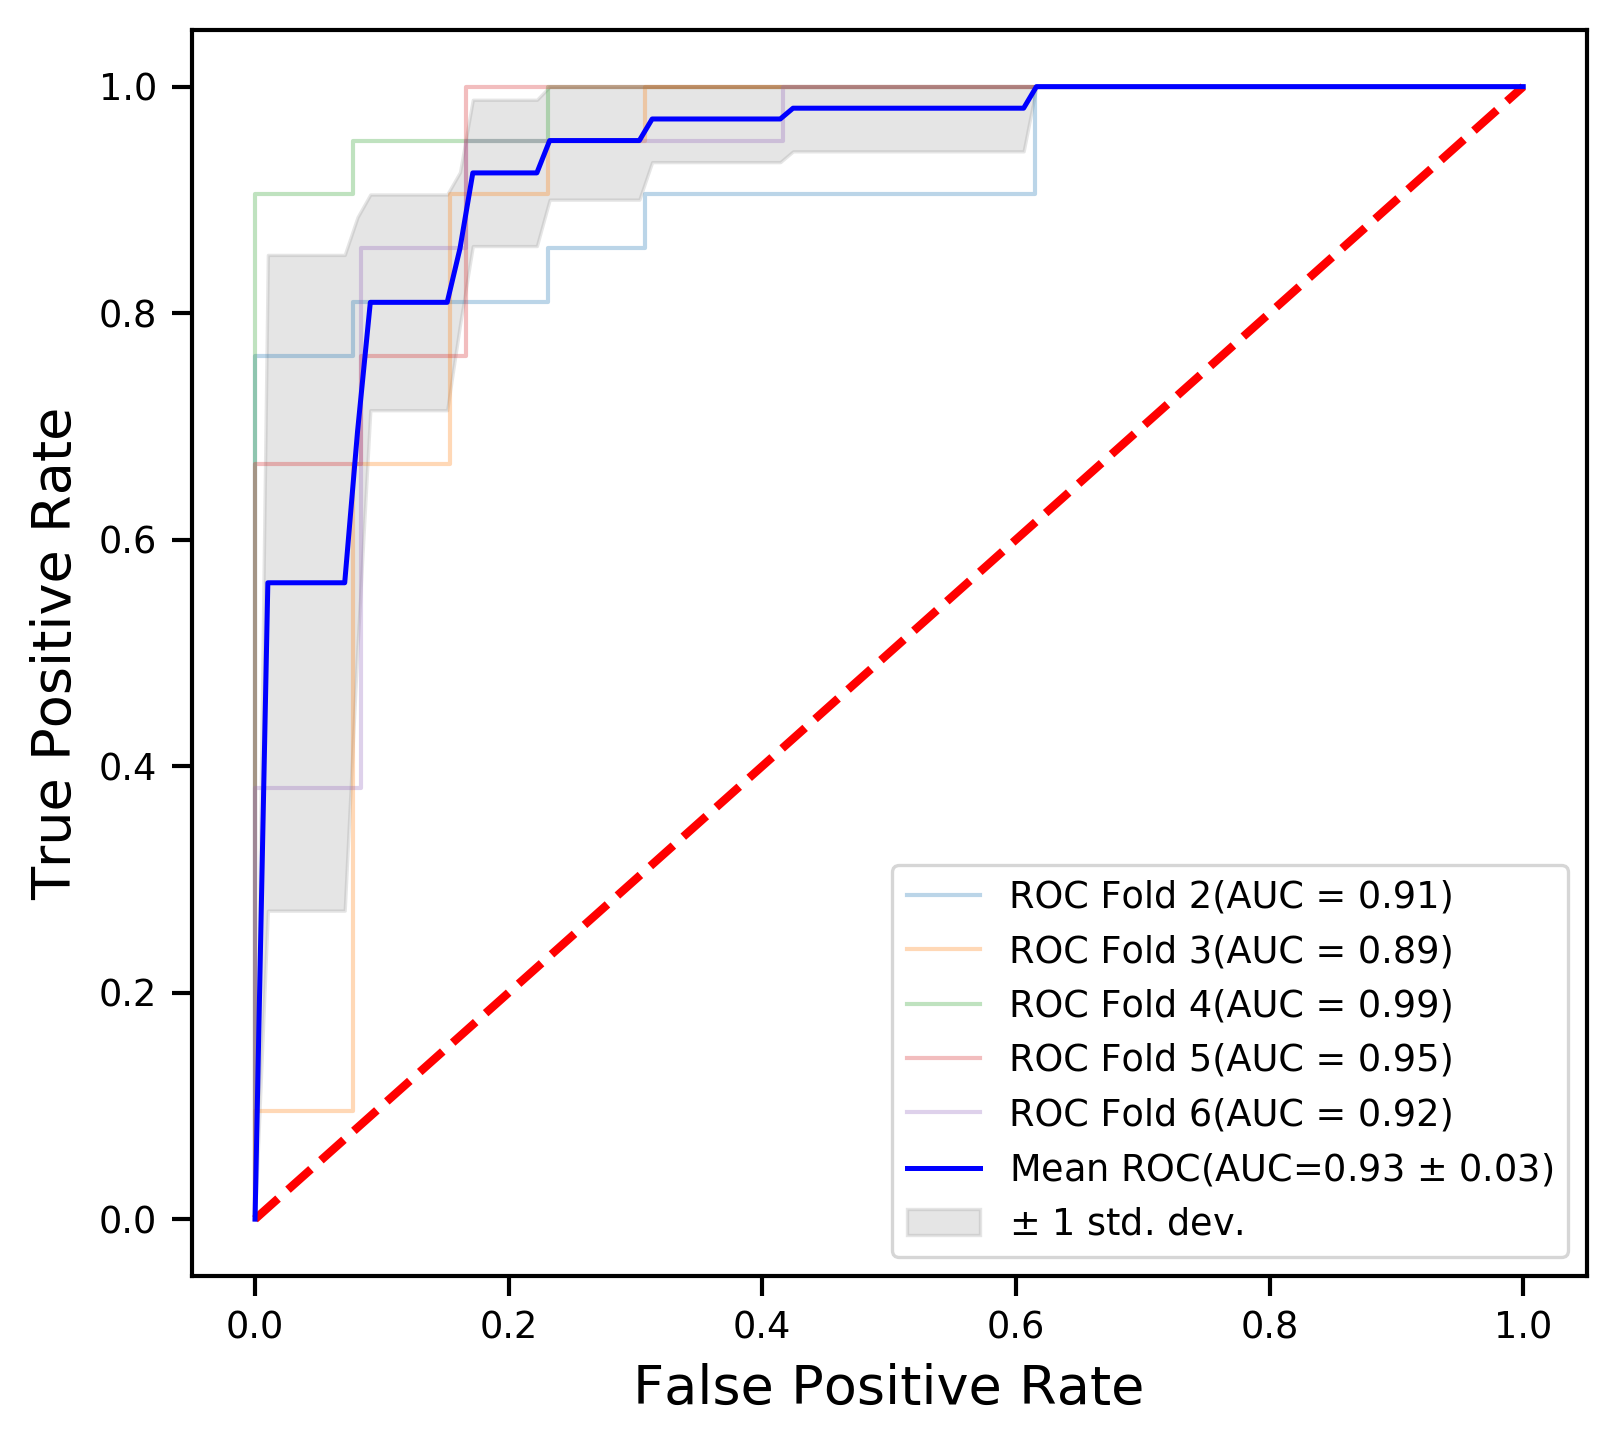

In [162]:
statistic_asv = pd.read_csv('../result/Microbiome/differential_asv.csv', index_col=0)
sig_asv = (statistic_asv['FDR']<=FDR_THRESHOLD)
statistic_asv = statistic_asv.loc[sig_asv, :].sort_values(['FDR'])
temp = asv_data.loc[statistic_asv.index, :]
###
X = temp.T.values
Y = np.array([0 if i[0]=='N' else 1 for i in temp.columns])
res = try_Models(X, Y)
###
clf = RandomForestClassifier(n_estimators=501, max_depth=5, class_weight='balanced', random_state=RANDOM_SEED)
plot_auc(X, Y, clf)